In [77]:
import numpy as np
from filterpy.kalman import KalmanFilter
import pandas as pd
import datetime
import matplotlib.pyplot as plt

In [78]:
# Data cleaning
df = pd.read_csv("Cleaned Datasets/US_Full_Quarterly.csv")
df["Log GDP"] = np.log(df["GDP"])
df['Diff Log GDP'] = df['Log GDP'] - df['Log GDP'].shift(1)
df.set_index("DATE", drop=True, inplace=True)
#variables = ['GDP', 'College','Fertility']
#df = df[variables]
df.dropna(inplace=True)
df = df[df.index <= "2017"]
df

,GDP,Inv,Exp,Imp,Gov,Cons,NXP,Fertility,Unemployment,Life_exp,...,High_School,College,recession_1973,recession_1980,recession_1990,recession_2001,recession_2008,recession_2020,Log GDP,Diff Log GDP
DATE,,,,,,,,,,,,,,,,,,,,,
1960-01-01,542.648,96.476,26.145,23.288,90.543,323.6,2.857,3.6540,5.2,69.770732,...,41.10,7.70,0,0,0,0,0,0,6.296461,0.026229
1960-04-01,541.080,87.096,26.850,23.455,92.628,336.5,3.395,3.6540,5.2,69.770732,...,41.10,7.70,0,0,0,0,0,0,6.293567,-0.002894
1960-07-01,545.604,86.377,27.561,22.879,93.723,331.4,4.682,3.6540,5.5,69.770732,...,41.10,7.70,0,0,0,0,0,0,6.301893,0.008326
1960-10-01,540.197,75.963,27.622,21.742,96.698,335.4,5.880,3.6540,6.1,69.770732,...,41.10,7.70,0,0,0,0,0,0,6.291934,-0.009960
1961-01-01,545.018,78.378,27.560,21.658,96.510,332.2,5.902,3.6200,6.6,70.270732,...,42.68,8.04,0,0,0,0,0,0,6.300819,0.008885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-10-01,18435.137,3276.879,2222.279,2745.517,4050.403,12394.9,-523.238,1.8435,5.0,78.690244,...,88.40,32.50,1,1,1,1,1,0,9.822014,0.001819
2016-01-01,18525.933,3244.317,2181.957,2693.639,4084.292,12478.0,-511.682,1.8205,4.8,78.539024,...,89.10,33.40,1,1,1,1,1,0,9.826927,0.004913
2016-04-01,18711.702,3246.381,2221.936,2711.306,4101.647,12611.5,-489.370,1.8205,5.1,78.539024,...,89.10,33.40,1,1,1,1,1,0,9.836904,0.009978


In [79]:
# Define the function to calculate AIC
def calculate_aic(filtered_states, true_state, k, log_l):
    n = len(filtered_states)
    # AIC calculation
    aic = 2 * k * (1 + (k+1)/(n-k)) - 2 * log_l
    return aic


In [80]:
def KalmanTrain(df, dimensionSearch=10):

    aic = np.inf
    filtered_state = []

    x_opt = 0
    F_opt = 0
    H_opt = 0

    # Iterate to find best dimensions
    for d in range(1, dimensionSearch):
        # Initialize 10 random points
        log_likelihood = 0
        f = KalmanFilter(dim_x=d, dim_z=len(df.columns))
        f.x = np.random.normal(size=(d,1))
        f.F = np.random.normal(size=(d,d))
        f.H = np.random.normal(size=(len(df.columns),d))

        # Run Kalman filter
        for z in df.values:
            f.predict()
            f.update(z)
            log_likelihood += f.log_likelihood_of(z)
            filtered_state.append(f.x.flatten())

        # Compute and compare AIC
        curr_aic = calculate_aic(filtered_state, df, d, log_likelihood)
        if curr_aic < aic:
            aic = curr_aic
            optimalModel = f
            x_opt = f.x.copy()
            F_opt = f.F.copy()
            H_opt = f.H.copy()
            optimalStateDimension = d
    
    return optimalStateDimension, x_opt, F_opt, H_opt

In [81]:
def filter(f,zs):
    n = np.size(zs,0)
    # initialize
    xhat = np.zeros((n,f.dim_x,1))
    Ps = np.zeros((n,f.dim_x,f.dim_x))
    z_filtered = np.zeros((n,f.dim_z))
    for i,z in enumerate(zs):
        f.predict()
        f.update(z)
        xhat[i] = f.x.copy()
        Ps[i] = f.P.copy()
        z_filtered[i] = (f.H)@(xhat[i].reshape(f.dim_x,))
        
    return xhat, Ps, z_filtered

def predict(f, zs, stepsForward):
    xhat, Ps, z_filtered = filter(f, zs)
    xhat_predict = np.zeros((stepsForward, f.dim_x, 1))
    Ps_predict = np.zeros((stepsForward, f.dim_x, f.dim_x))
    z_predicts = np.zeros((stepsForward, f.dim_z))

    for i in range(stepsForward):
        f.predict()
        xhat_predict[i] = f.x.copy()
        Ps[i] = f.P.copy()
        z_predicts[i] = (f.H)@(xhat_predict[i].reshape(f.dim_x,))
    
    return np.vstack((xhat, xhat_predict)), 0, np.vstack((z_filtered, z_predicts))
        

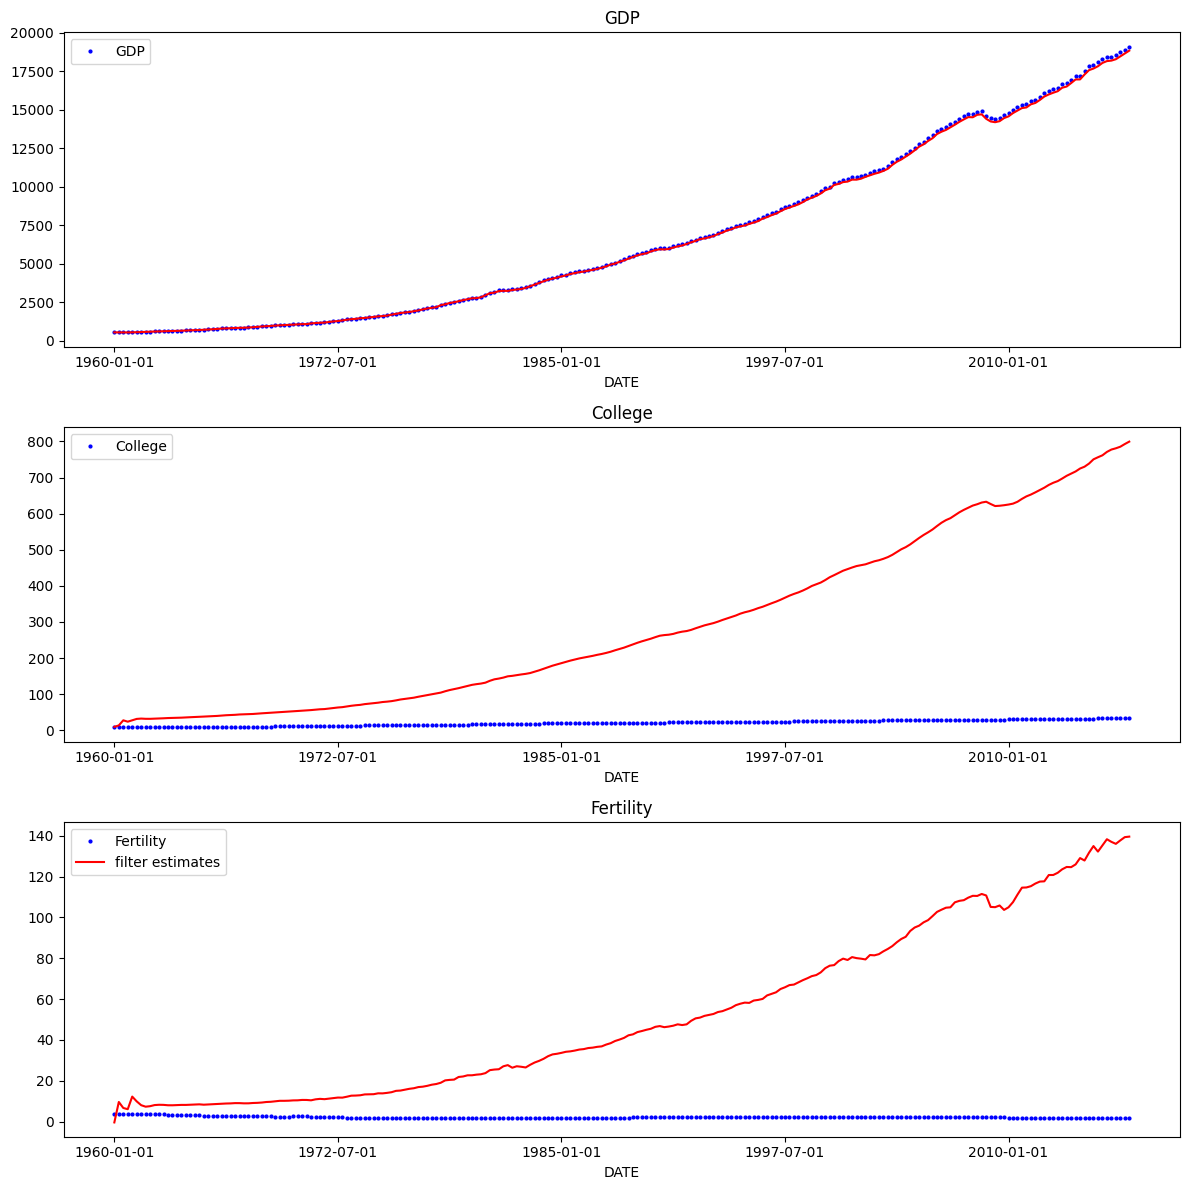

In [83]:
def KalmanFilterTrainAndGraph(df, y="GDP", stepsForward=0, dimensionSearch=10):
    # Format the data
    data = df.copy()
    data = data[[y, 'College', 'Fertility']]

    # Train the model, calculate the optimal dimension and parameters
    d, x, F, H = KalmanTrain(data)

    
    f = KalmanFilter(dim_x=d, dim_z=len(data.columns))
    f.x = np.random.normal(size=(d,1))
    f.F = F.copy()
    f.H = H.copy()

    xhat, Ps, z_predicts = predict(f, data.to_numpy(), stepsForward)

    # Plot the results
    fig, axs = plt.subplots(3,1,figsize=(12,12))

    data[[y]].plot(ax=axs[0], color='b', marker='o', label="Original Data", markersize=2, linestyle='none')
    axs[0].plot(np.arange(z_predicts[:,0].size), z_predicts[:,0], label='filter estimates', color="r")
    axs[0].set_title(y)


    data[['College']].plot(ax=axs[1], color='b', marker='o', label="Original Data", markersize=2, linestyle='none')
    axs[1].plot(np.arange(z_predicts[:,1].size), z_predicts[:,1], label='filter estimates', color="r")
    axs[1].set_title("College")

    data[['Fertility']].plot(ax=axs[2], color='b', marker='o', label="Original Data", markersize=2, linestyle='none')
    axs[2].plot(np.arange(z_predicts[:,2].size), z_predicts[:,2], label='filter estimates', color="r")
    axs[2].set_title("Fertility")

    plt.legend()
    plt.tight_layout()
    plt.show()

    return None

KalmanFilterTrainAndGraph(df)